In [294]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [295]:
pd.options.display.float_format = '{:.2f}'.format


In [296]:
# Importando dados de Excel com população por estado 
df_pop = pd.read_excel("C:\\Users\\corpc34475\\OneDrive - CVC Brasil Operadora e Agencia de Viagens S.A\\projetos\\estudo\\pos-tech-data-analytics\\fase_1\\visualizacao_de_dados\\dados\\estimativa_dou_2020.xls", sheet_name='BRASIL E UFs', skiprows=1, skipfooter=7, usecols=['BRASIL E UNIDADES DA FEDERAÇÃO', 'POPULAÇÃO ESTIMADA'])

# Importando dados de gastos 
df_gastos = pd.read_csv(
    "C:\\Users\\corpc34475\\OneDrive - CVC Brasil Operadora e Agencia de Viagens S.A\\projetos\\estudo\\pos-tech-data-analytics\\fase_1\\visualizacao_de_dados\\dados\\A150850189_28_143_208 (1).csv", 
    sep=';', 
    encoding='latin', 
    skiprows=3,
    skipfooter=12,
    na_values=['-'],
    decimal=','
)

C:\Users\corpc34475\AppData\Local\Temp\ipykernel_12532\2746080465.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df_gastos = pd.read_csv(


In [297]:
# Renomeando colunas
df_pop.columns = ['uf','populacao_estimada']

In [298]:
# Criando coluna de id das regiões

x = 0
list_cat = []
for i in df_pop['uf']:
    if i.find('Região') >= 0:
        x += 1
        list_cat.append(x)

    else:
        list_cat.append(x)

print(list_cat)

df_pop['regiao_id'] = list_cat

[0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 5]


In [299]:
# Removendo linhas com dados do Brasil e regiões
df_pop_estados = df_pop[~((df_pop['uf'].str.contains("Região")) | (df_pop['uf'] == 'Brasil'))].reset_index(drop=True)

df_regiao = df_pop[((df_pop['uf'].str.contains("Região")) | (df_pop['uf'] == 'Brasil'))].reset_index(drop=True)[['regiao_id','uf']].rename(columns={'uf':'regiao'})

df_pop_estados = df_pop_estados.set_index('regiao_id').join(other=df_regiao.set_index('regiao_id'), on='regiao_id', how='left').reset_index()

In [300]:
# Tratando colunas
df_pop_estados['populacao_estimada'] = df_pop_estados['populacao_estimada'].astype('str').str.replace(pat='\(\d*\)', repl='', regex=True).str.replace(pat='.', repl='', regex=True).astype('int')

# Adicionando uma coluna na primeira posição do DF
df_gastos.insert(loc=0, column='uf', value=df_gastos['Unidade da Federação'].str.replace(pat='^\d*\s', repl='', regex=True), allow_duplicates=True)

In [301]:
# Adicionando estimativa da população ao DF de gastos
df_complete = df_gastos.set_index('uf').join(other=df_pop_estados.set_index('uf'), on='uf', how='left').reset_index()

In [302]:
# Função para devolver a lista de colunas de meses
def list_last_months(df_months, qtd_months, lag:int=0):
    if lag == 0:
        ls_result = df_months.drop(columns=['uf','Unidade da Federação','Total','regiao_id','populacao_estimada','regiao']).columns[-qtd_months:]
    elif lag > 0:
        ls_result = df_months.drop(columns=['uf','Unidade da Federação','Total','regiao_id','populacao_estimada','regiao']).columns[-(lag+1)*qtd_months:-qtd_months]

    return ls_result

In [303]:
# Criando novas colunas
df_complete['gastos_2021ago_por_pessoa'] = df_complete['2021/Ago'] / df_complete['populacao_estimada']
df_complete['gastos_2021jul_por_pessoa'] = df_complete['2021/Jul'] / df_complete['populacao_estimada']

df_complete['gastos_last12_mes'] = df_complete[list_last_months(df_months=df_complete, qtd_months=12)].apply(np.sum, axis='columns')
df_complete['gastos_last12_mes_lag1'] = df_complete[list_last_months(df_months=df_complete, qtd_months=12, lag=1)].apply(np.sum, axis='columns')

# Selecionando colunas importantes
df_complete = df_complete[['uf','2021/Jul','2021/Ago','gastos_last12_mes','gastos_last12_mes_lag1','gastos_2021jul_por_pessoa','gastos_2021ago_por_pessoa','populacao_estimada','regiao']].set_index('uf')


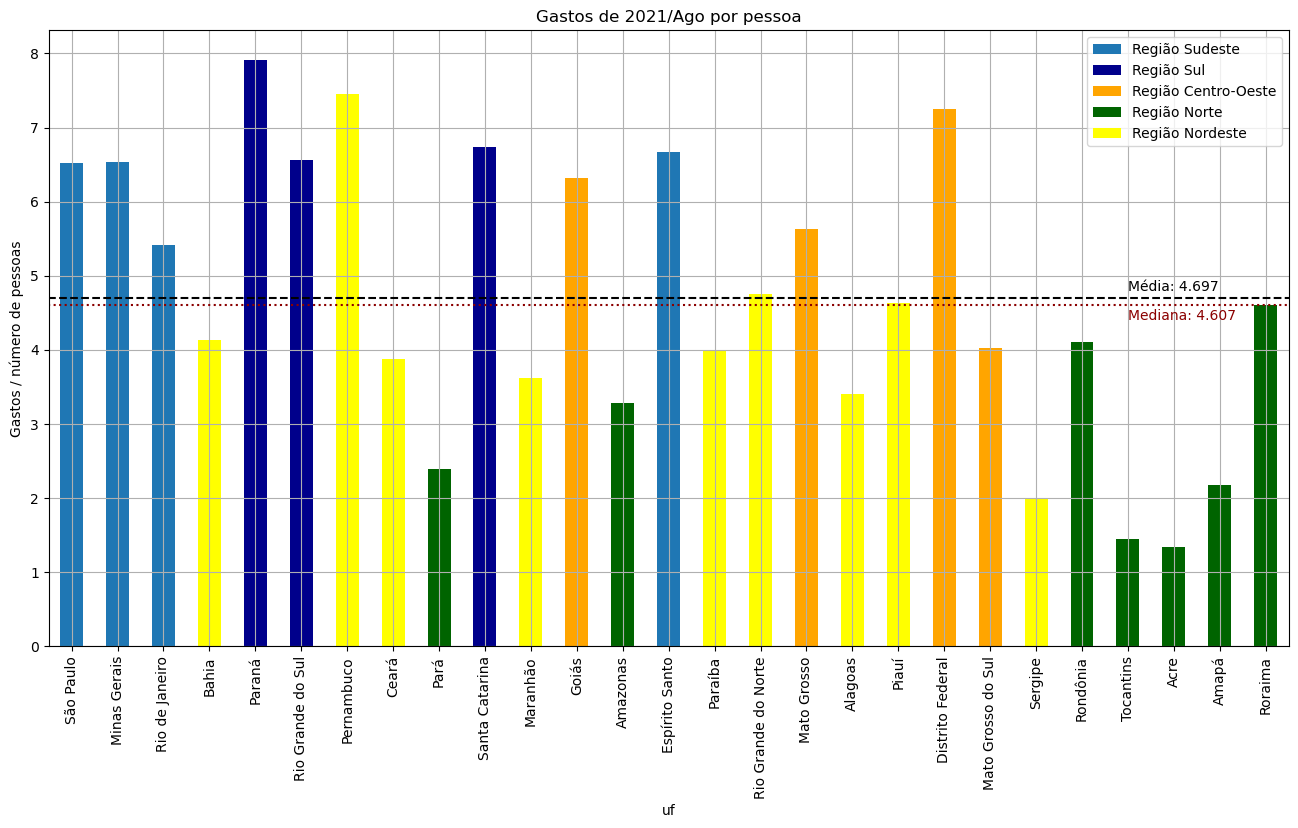

In [304]:
media_gastos_pessoa = df_complete['gastos_2021ago_por_pessoa'].mean()
mediana_gastos_pessoa = df_complete['gastos_2021ago_por_pessoa'].median()

ax = df_complete.sort_values(by='populacao_estimada', ascending=False)['gastos_2021ago_por_pessoa'].plot(kind='bar', figsize=(16,8))
ax.set_title("Gastos de 2021/Ago por pessoa")
ax.set_ylabel("Gastos / número de pessoas")


# Adicionando outra cores para as regiões
df_complete.sort_values(by='populacao_estimada', ascending=False).where(df_complete['regiao'] == 'Região Sul')['gastos_2021ago_por_pessoa'].plot(kind='bar', figsize=(16,8), color='darkblue')
df_complete.sort_values(by='populacao_estimada', ascending=False).where(df_complete['regiao'] == 'Região Centro-Oeste')['gastos_2021ago_por_pessoa'].plot(kind='bar', figsize=(16,8), color='orange')
df_complete.sort_values(by='populacao_estimada', ascending=False).where(df_complete['regiao'] == 'Região Norte')['gastos_2021ago_por_pessoa'].plot(kind='bar', figsize=(16,8), color='darkgreen')
df_complete.sort_values(by='populacao_estimada', ascending=False).where(df_complete['regiao'] == 'Região Nordeste')['gastos_2021ago_por_pessoa'].plot(kind='bar', figsize=(16,8), color='yellow')
ax.legend(['Região Sudeste','Região Sul','Região Centro-Oeste','Região Norte','Região Nordeste'])
ax.grid(True)

# Adicionando linha horizantal com a média
plt.plot([-1,100], [media_gastos_pessoa, media_gastos_pessoa], ls='dashed', color='black')
plt.annotate(f"Média: {round(media_gastos_pessoa,3)}", xy=(23,media_gastos_pessoa+.1), color='black')

# Adicionando linha horizantal com a mediana
plt.plot([-1,100], [mediana_gastos_pessoa, mediana_gastos_pessoa], ls='dotted', color='darkred')
plt.annotate(f"Mediana: {round(mediana_gastos_pessoa,3)}", xy=(23,mediana_gastos_pessoa-.2), color='darkred')

plt.show()


In [305]:
df_complete

,2021/Jul,2021/Ago,gastos_last12_mes,gastos_last12_mes_lag1,gastos_2021jul_por_pessoa,gastos_2021ago_por_pessoa,populacao_estimada,regiao
uf,,,,,,,,
Rondônia,11834435.10,7371334.84,119077462.96,109398620.08,6.59,4.10,1796460,Região Norte
Acre,2302711.01,1196754.85,35265456.80,40498871.15,2.57,1.34,894470,Região Norte
Amazonas,21614943.55,13806958.66,210961589.27,218310219.65,5.14,3.28,4207714,Região Norte
Roraima,3320807.96,2907871.07,35425710.94,36865268.34,5.26,4.61,631181,Região Norte
Pará,33718084.12,20837865.89,370225082.42,450268671.07,3.88,2.40,8690745,Região Norte
Amapá,4136950.62,1875241.91,35186145.89,30342246.04,4.80,2.18,861773,Região Norte
Tocantins,4610170.61,2304080.49,70702362.95,95238156.68,2.90,1.45,1590248,Região Norte
Maranhão,37775425.78,25779674.83,387185213.94,383769259.40,5.31,3.62,7114598,Região Nordeste
Piauí,19972846.10,15220885.72,229670498.52,226053408.92,6.09,4.64,3281480,Região Nordeste


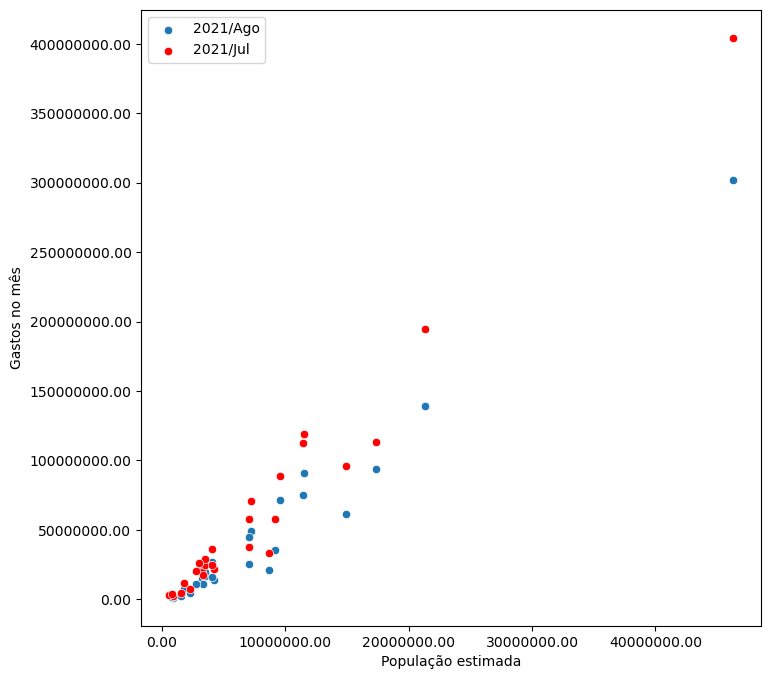

In [306]:
import matplotlib.ticker as ticker

fig = plt.figure(figsize=(8,8))
ax = sns.scatterplot(data=df_complete, x='populacao_estimada', y='2021/Ago')
ax2 = sns.scatterplot(data=df_complete, x='populacao_estimada', y='2021/Jul', color='red')
ax.set_ylabel("Gastos no mês")
ax.set_xlabel("População estimada")
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.2f}'))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.2f}'))
ax.legend(['2021/Ago','2021/Jul'])

plt.show()

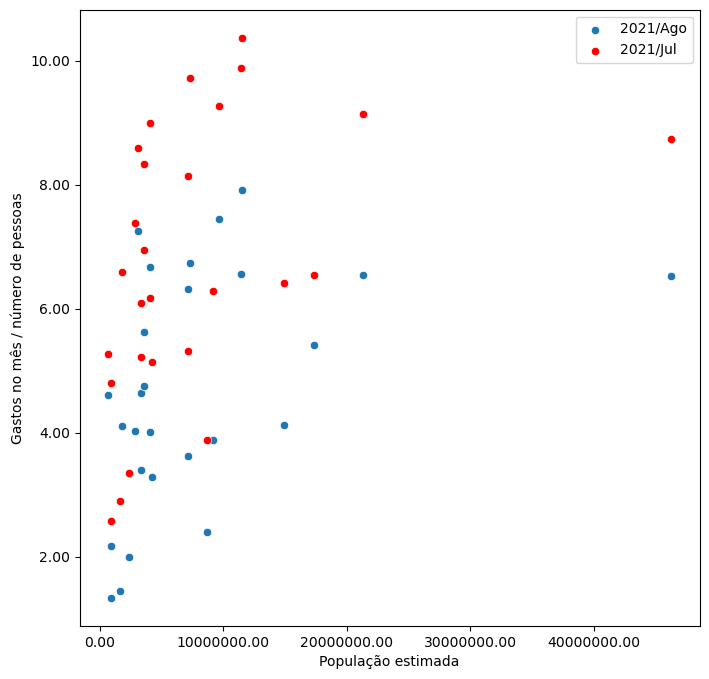

In [307]:
fig = plt.figure(figsize=(8,8))
ax = sns.scatterplot(data=df_complete, x='populacao_estimada', y='gastos_2021ago_por_pessoa')
ax2 = sns.scatterplot(data=df_complete, x='populacao_estimada', y='gastos_2021jul_por_pessoa', color='red')
ax.set_ylabel("Gastos no mês / número de pessoas")
ax.set_xlabel("População estimada")
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.2f}'))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.2f}'))
ax.legend(['2021/Ago','2021/Jul'])

plt.show()

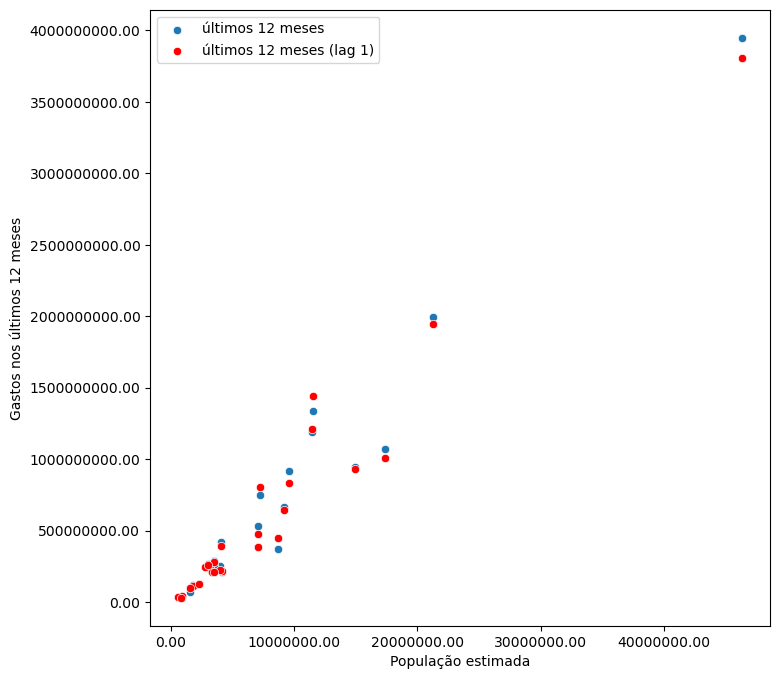

In [308]:
fig = plt.figure(figsize=(8,8))
ax = sns.scatterplot(data=df_complete, x='populacao_estimada', y='gastos_last12_mes')
ax2 = sns.scatterplot(data=df_complete, x='populacao_estimada', y='gastos_last12_mes_lag1', color='red')
ax.set_ylabel("Gastos nos últimos 12 meses")
ax.set_xlabel("População estimada")
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.2f}'))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.2f}'))
ax.legend(['últimos 12 meses','últimos 12 meses (lag 1)'])

plt.show()

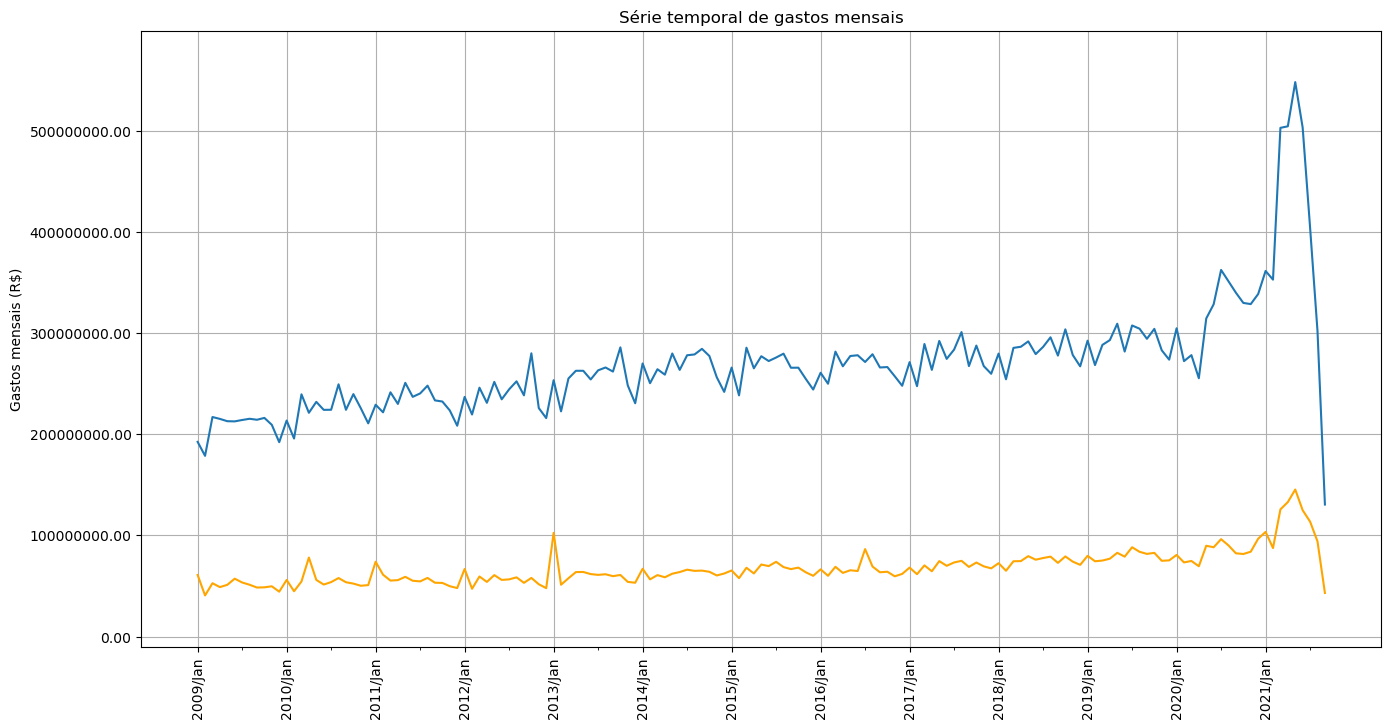

In [309]:
import matplotlib.ticker as ticker

# Série temporal
estado_1 = 'São Paulo'
estado_2 = 'Rio de Janeiro'

df_visao_mes = df_gastos.drop(columns=['Unidade da Federação','Total']).set_index('uf').T.loc['2009/Jan':] # Selecionando dados a partir de "2008/Jan"

# Estatísticas dos estados
max_1 = df_visao_mes[estado_1].max()
min_1= df_visao_mes[estado_1].min()
max_2 = df_visao_mes[estado_2].max()
min_2= df_visao_mes[estado_2].min()
max_global = max([max_1,max_2,min_1,min_2])
min_global = min([max_1,max_2,min_1,min_2])
aplitude_global = max_global - min_global 
li = min([0, min_global - 0.1*aplitude_global])
ls = max_global + 0.1*aplitude_global


plt.figure(figsize=(16,8))
ax = sns.lineplot(data=df_visao_mes, x=df_visao_mes.index, y=estado_1)
ax.xaxis.set_major_locator(ticker.IndexLocator(12, offset=0))
ax.xaxis.set_minor_locator(ticker.IndexLocator(6, offset=6))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))
ax_2 = sns.lineplot(data=df_visao_mes, x=df_visao_mes.index, y=estado_2, color='orange')
plt.title("Série temporal de gastos mensais")
plt.ylabel("Gastos mensais (R$)")
plt.ylim((li, ls))
plt.xticks(rotation=90)
plt.grid(True)
# ax.legend([estado_1])
# ax.legend(handles_map=[ax,ax_2])

plt.show()

In [310]:
# Aplicando melt no DF (Unpivot)
# df_visao_mes.columns
# df_visao_mes['Rondônia']
# df_visao_mes

# Etapa 1 - Transformar o index em uma coluna no formato da date
def cleanStrYearMonth(year_month_str):
    
    from datetime import date

    months = {
        "Jan":1, "Fev":2, "Mar":3, "Abr":4, "Mai":5, "Jun":6,
        "Jul":7, "Ago":8, "Set":9, "Out":10, "Nov":11, "Dez":12
    }

    ls_year_month = year_month_str.replace("\t", '').split("/")
    y:int = int(ls_year_month[0])
    m:int = months[ls_year_month[1]]

    return date(year=y, month=m, day=1)


df_unpivot = df_visao_mes.set_index(df_visao_mes.index.map(cleanStrYearMonth)).reset_index().rename(columns={'index':'data'}) 


# Etapa 2 - Aplicar o melt (unpivot) 
df_unpivot = df_unpivot.melt(id_vars=['data'], value_vars=df_visao_mes.columns, var_name='estado', value_name='gasto')

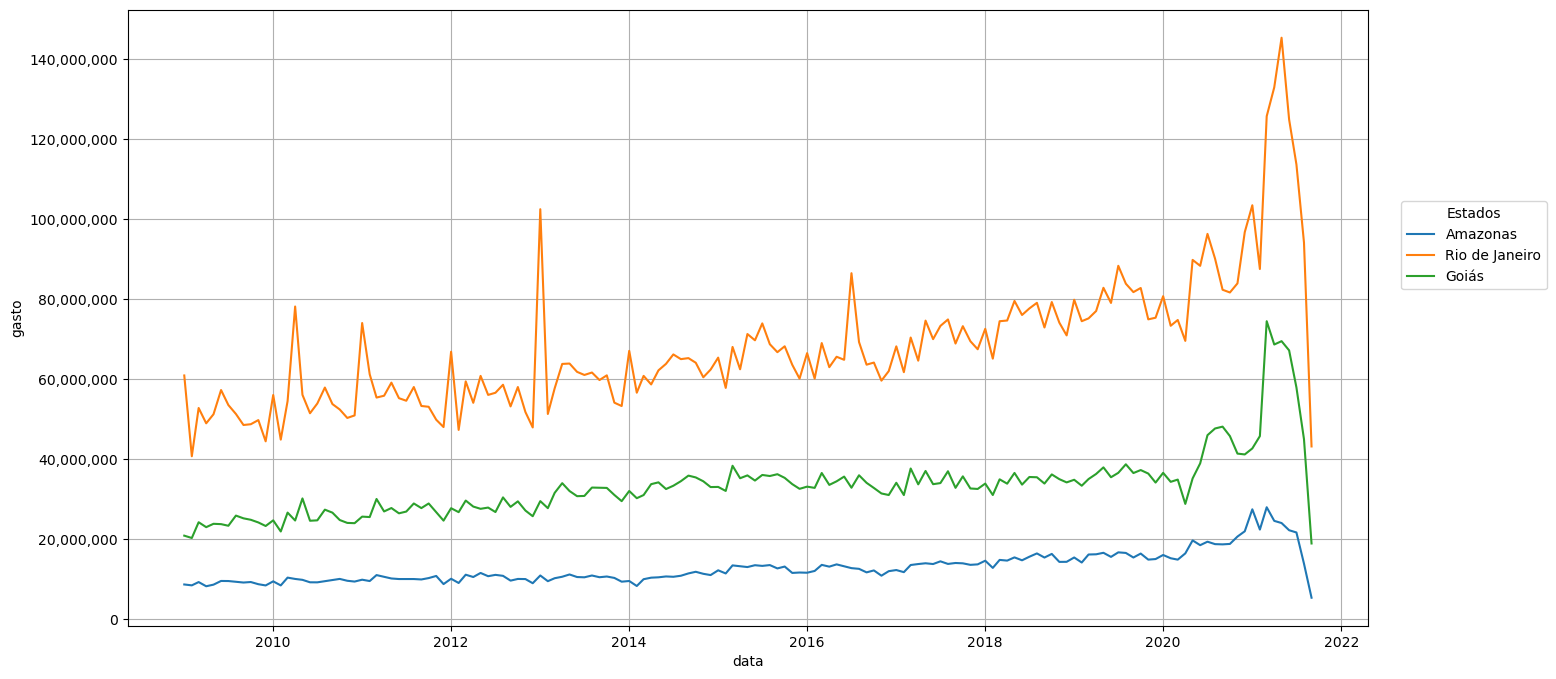

In [311]:
import matplotlib.ticker as ticker


fig = plt.figure(figsize=(16,8))
ax = sns.lineplot(data=df_unpivot[df_unpivot['estado'].isin(['Rio de Janeiro','Goiás','Amazonas'])], x='data', y='gasto', hue='estado')
ax.legend(title='Estados', loc='best', bbox_to_anchor=(1.15,0.7))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
sns.color_palette("hls", 8)

ax.grid(True)

In [312]:
# Trantando a coluna date e criando novas colunas
df_unpivot['data'] = pd.to_datetime(df_unpivot['data'])
df_unpivot['ano'] = df_unpivot['data'].dt.year
df_unpivot['mes'] = df_unpivot['data'].dt.month

# Aproximação da qtd de dias por mês
qtd_dias = {
    1:31, 2:28, 3:31, 4:30, 5:31, 6:30,
    7:31, 8:31, 9:30, 10:31, 11:30, 12:31
}

months = {
    1:"Jan", 2:"Fev", 3:"Mar", 4:"Abr", 5:"Mai", 6:"Jun",
    7:"Jul", 8:"Ago", 9:"Set", 10:"Out", 11:"Nov", 12:"Dez"
}

df_unpivot['qtd_dias'] = df_unpivot['mes'].map(qtd_dias)
df_unpivot['mes_nome'] = df_unpivot['mes'].map(months)
df_unpivot['gastos_por_dia'] = df_unpivot['gasto'] / df_unpivot['qtd_dias']

# Adicionando a população estimada
df_unpivot = df_unpivot.set_index('estado').join(
    other=df_complete[['populacao_estimada','regiao']].reset_index().rename(columns={'uf':'estado'}).set_index('estado'),
    on='estado',
    how='left'
).reset_index()

# Gastos por população
df_unpivot['gastos_por_pop'] = df_unpivot['gasto'] / df_unpivot['populacao_estimada']

# Gastos dos últimos 12 mês de cada estado
df_unpivot['gastos_ult12meses'] = df_unpivot.groupby('estado')['gasto'].transform(lambda x: x.rolling(12).sum())
# df_unpivot['gastos_ult12meses'] = df_unpivot.groupby('estado')['gasto'].rolling(12).sum()

# Gastos dos últimos 12 mês de cada estado por pop
df_unpivot['gastos_ult12meses_por_pop'] = df_unpivot['gastos_ult12meses'] / df_unpivot['populacao_estimada']


df_unpivot

,estado,data,gasto,ano,mes,qtd_dias,mes_nome,gastos_por_dia,populacao_estimada,regiao,gastos_por_pop,gastos_ult12meses,gastos_ult12meses_por_pop
0,Rondônia,2009-01-01,3147566.24,2009,1,31,Jan,101534.39,1796460,Região Norte,1.75,NaN,NaN
1,Rondônia,2009-02-01,3082108.12,2009,2,28,Fev,110075.29,1796460,Região Norte,1.72,NaN,NaN
2,Rondônia,2009-03-01,4190355.33,2009,3,31,Mar,135172.75,1796460,Região Norte,2.33,NaN,NaN
3,Rondônia,2009-04-01,4040251.62,2009,4,30,Abr,134675.05,1796460,Região Norte,2.25,NaN,NaN
4,Rondônia,2009-05-01,3946423.71,2009,5,31,Mai,127303.99,1796460,Região Norte,2.20,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4126,Distrito Federal,2021-05-01,32434557.27,2021,5,31,Mai,1046276.04,3055149,Região Centro-Oeste,10.62,316961363.24,103.75
4127,Distrito Federal,2021-06-01,27196457.00,2021,6,30,Jun,906548.57,3055149,Região Centro-Oeste,8.90,319108210.59,104.45
4128,Distrito Federal,2021-07-01,26265515.44,2021,7,31,Jul,847274.69,3055149,Região Centro-Oeste,8.60,318924888.95,104.39
4129,Distrito Federal,2021-08-01,22156437.60,2021,8,31,Ago,714723.79,3055149,Região Centro-Oeste,7.25,317187006.33,103.82


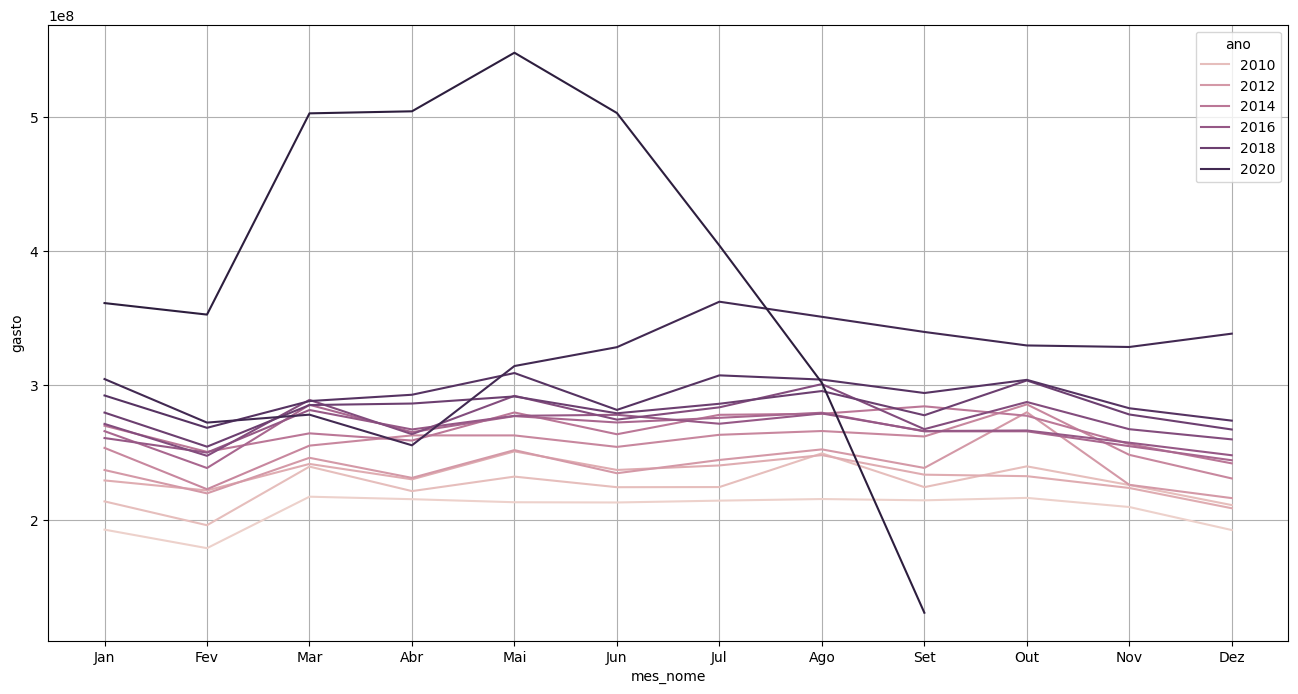

In [291]:
fig = plt.figure(figsize=(16,8))

ax = sns.lineplot(data=df_unpivot.query("estado == 'São Paulo'"), x='mes_nome', y='gasto', hue='ano')
ax.grid(True)

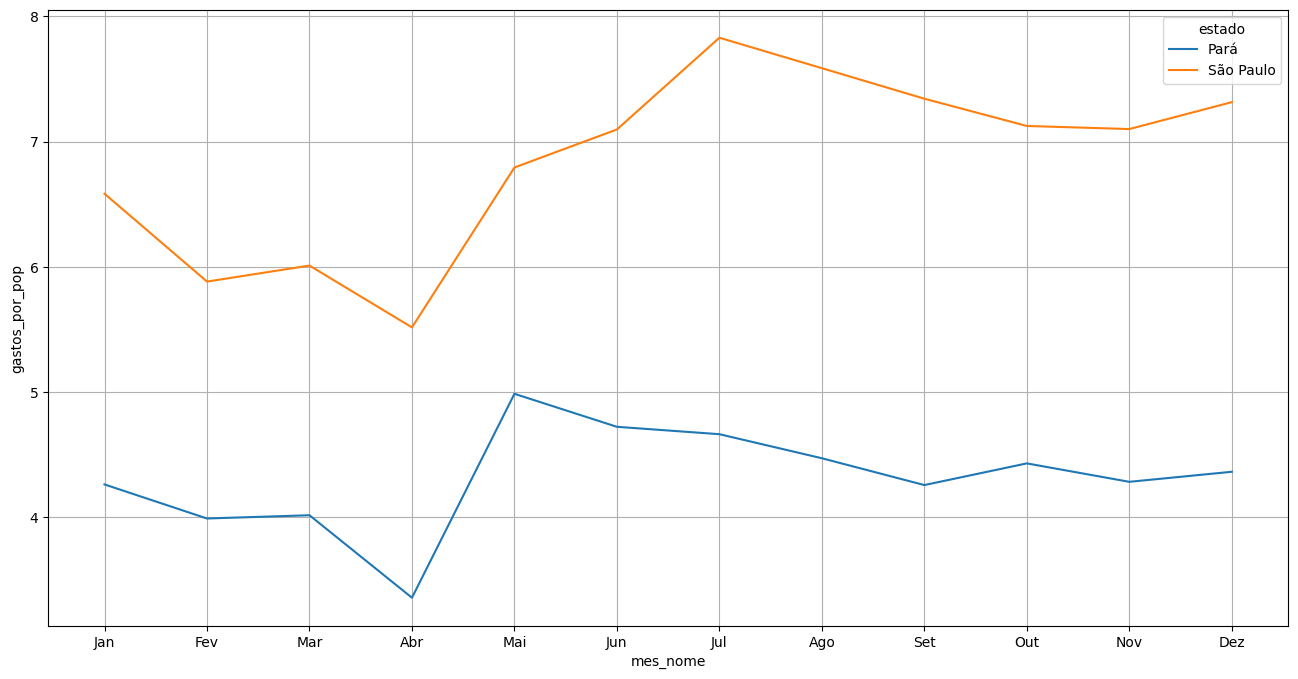

In [292]:
fig = plt.figure(figsize=(16,8))

ax = sns.lineplot(data=df_unpivot.query("estado.isin(['São Paulo','Pará']) & ano == 2020"), x='mes_nome', y='gastos_por_pop', hue='estado')
ax.grid(True)

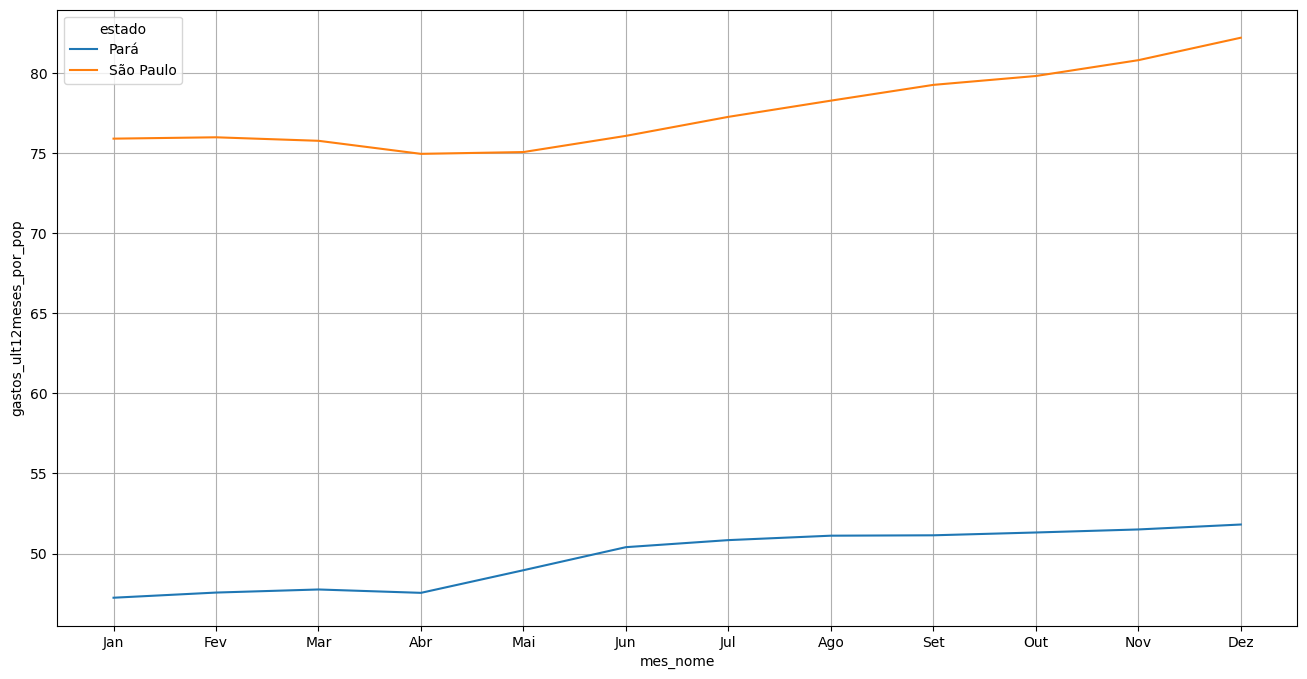

In [315]:
fig = plt.figure(figsize=(16,8))

ax = sns.lineplot(data=df_unpivot.query("estado.isin(['São Paulo','Pará']) & ano == 2020"), x='mes_nome', y='gastos_ult12meses_por_pop', hue='estado')
ax.grid(True)